## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

ref:  
[Usage of regularizers](https://keras.io/regularizers/)

In [5]:
#from keras.regularizers import l1, l2, l1_l2
from keras import regularizers
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], regularizer_type='', parameters={}):
    input_layer = keras.layers.Input(input_shape)

    '''
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    '''
    x = input_layer
    if regularizer_type == 'l1':
        l1 = parameters['l1']
        regularizer = regularizers.l1(l1)
    elif regularizer_type == 'l2':
        l2 = parameters['l2']
        regularizer = regularizers.l2(l2)
    elif regularizer_type == 'l1_l2':
        l1 = parameters['l1']
        l2 = parameters['l2']
        regularizer = regularizers.l1_l2(l1=l1, l2=l2)
    else:
        return None
        
    for i, n_units in enumerate(num_neurons):
        x = keras.layers.Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1),
                               kernel_regularizer=regularizer)(x)
                               #activity_regularizer=l1(0.01)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
#regularizers_list = [1e-2, 1e-4, 1e-8, 1e-12]
regularizers_list = [
    #('type', 'parameter')    #(type=l1/l2/l1_l2)
    ('l1', {'l1':1e-2}),
    ('l1', {'l1':1e-4}),
    ('l1', {'l1':1e-8}),
    ('l1', {'l1':1e-12}),

    #default: l1_l2(l1=0.01, l2=0.01)
    ('l1_l2', {'l1':1e-2, 'l2':1e-2}),
    ('l1_l2', {'l1':1e-2, 'l2':1e-4}),
    ('l1_l2', {'l1':1e-2, 'l2':1e-8}),
    ('l1_l2', {'l1':1e-2, 'l2':1e-12}),
    
    ('l1_l2', {'l1':1e-4, 'l2':1e-2}),
    ('l1_l2', {'l1':1e-4, 'l2':1e-4}),
    ('l1_l2', {'l1':1e-4, 'l2':1e-8}),
    ('l1_l2', {'l1':1e-4, 'l2':1e-12}),
    
    ('l1_l2', {'l1':1e-8, 'l2':1e-2}),
    ('l1_l2', {'l1':1e-8, 'l2':1e-4}),
    ('l1_l2', {'l1':1e-8, 'l2':1e-8}),
    ('l1_l2', {'l1':1e-8, 'l2':1e-12}),
    
    ('l1_l2', {'l1':1e-12, 'l2':1e-2}),
    ('l1_l2', {'l1':1e-12, 'l2':1e-4}),
    ('l1_l2', {'l1':1e-12, 'l2':1e-8}),
    ('l1_l2', {'l1':1e-12, 'l2':1e-12}),
    
    ('l2', {'l2':1e-2}),
    ('l2', {'l2':1e-4}),
    ('l2', {'l2':1e-8}),
    ('l2', {'l2':1e-12}),
    ]

In [7]:
results = {}
for reg_test in regularizers_list:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    
    (reg_type, param) = reg_test

    model = build_mlp(input_shape=x_train.shape[1:], regularizer_type=reg_type, parameters=param)
    print(model.summary())
    
    print()
    print('-'*60)
    print(f"Experiment with Regulizer = '{reg_type}': {param}")
    print()

    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag  = f"type:'{reg_type}'"
    exp_name_tag += (f"-l1:{param['l1']}" if 'l1' in param else '')
    exp_name_tag += (f"-l2:{param['l2']}" if 'l2' in param else '')
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
None

------------------------------------------------------

50000/50000 [==============================] - 18s 356us/step - loss: 2.4626 - acc: 0.0997 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 48/50
50000/50000 [==============================] - 18s 355us/step - loss: 2.4626 - acc: 0.0975 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 49/50
50000/50000 [==============================] - 19s 373us/step - loss: 2.4626 - acc: 0.0980 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 18s 368us/step - loss: 2.4626 - acc: 0.0988 - val_loss: 2.4626 - val_acc: 0.1000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               1

Epoch 47/50
50000/50000 [==============================] - 17s 344us/step - loss: 2.7538 - acc: 0.6211 - val_loss: 3.0060 - val_acc: 0.5274
Epoch 48/50
50000/50000 [==============================] - 17s 346us/step - loss: 2.7156 - acc: 0.6241 - val_loss: 3.2009 - val_acc: 0.4769
Epoch 49/50
50000/50000 [==============================] - 17s 347us/step - loss: 2.6756 - acc: 0.6270 - val_loss: 2.9633 - val_acc: 0.5271
Epoch 50/50
50000/50000 [==============================] - 17s 347us/step - loss: 2.6350 - acc: 0.6282 - val_loss: 2.9600 - val_acc: 0.5169
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)    

50000/50000 [==============================] - 17s 347us/step - loss: 0.9147 - acc: 0.6788 - val_loss: 1.3646 - val_acc: 0.5314
Epoch 48/50
50000/50000 [==============================] - 17s 345us/step - loss: 0.9008 - acc: 0.6841 - val_loss: 1.4056 - val_acc: 0.5264
Epoch 49/50
50000/50000 [==============================] - 17s 344us/step - loss: 0.8899 - acc: 0.6896 - val_loss: 1.3901 - val_acc: 0.5274
Epoch 50/50
50000/50000 [==============================] - 17s 345us/step - loss: 0.8806 - acc: 0.6908 - val_loss: 1.3822 - val_acc: 0.5305
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               1

50000/50000 [==============================] - 17s 344us/step - loss: 0.9017 - acc: 0.6831 - val_loss: 1.4104 - val_acc: 0.5282
Epoch 48/50
50000/50000 [==============================] - 17s 345us/step - loss: 0.8861 - acc: 0.6902 - val_loss: 1.3979 - val_acc: 0.5299
Epoch 49/50
50000/50000 [==============================] - 17s 345us/step - loss: 0.8749 - acc: 0.6936 - val_loss: 1.4479 - val_acc: 0.5158
Epoch 50/50
50000/50000 [==============================] - 17s 345us/step - loss: 0.8606 - acc: 0.6990 - val_loss: 1.4207 - val_acc: 0.5233
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               1

50000/50000 [==============================] - 18s 368us/step - loss: 2.4615 - acc: 0.0976 - val_loss: 2.4615 - val_acc: 0.1000
Epoch 47/50
50000/50000 [==============================] - 18s 369us/step - loss: 2.4615 - acc: 0.0984 - val_loss: 2.4614 - val_acc: 0.1000
Epoch 48/50
50000/50000 [==============================] - 18s 369us/step - loss: 2.4614 - acc: 0.0971 - val_loss: 2.4613 - val_acc: 0.1000
Epoch 49/50
50000/50000 [==============================] - 18s 369us/step - loss: 2.4614 - acc: 0.0956 - val_loss: 2.4612 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 18s 370us/step - loss: 2.4614 - acc: 0.0979 - val_loss: 2.4613 - val_acc: 0.1000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)        

50000/50000 [==============================] - 18s 368us/step - loss: 2.4626 - acc: 0.0974 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 46/50
50000/50000 [==============================] - 18s 369us/step - loss: 2.4626 - acc: 0.0977 - val_loss: 2.4625 - val_acc: 0.10007s - - ETA: 2s -
Epoch 47/50
50000/50000 [==============================] - 18s 370us/step - loss: 2.4626 - acc: 0.0975 - val_loss: 2.4625 - val_acc: 0.1000- loss: 2.4626 - acc
Epoch 48/50
50000/50000 [==============================] - 18s 368us/step - loss: 2.4626 - acc: 0.0991 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 49/50
50000/50000 [==============================] - 18s 370us/step - loss: 2.4626 - acc: 0.0988 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 19s 371us/step - loss: 2.4626 - acc: 0.0985 - val_loss: 2.4625 - val_acc: 0.1000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inpu

50000/50000 [==============================] - 18s 368us/step - loss: 2.4626 - acc: 0.0974 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 45/50
50000/50000 [==============================] - 18s 369us/step - loss: 2.4626 - acc: 0.0978 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 46/50
50000/50000 [==============================] - 18s 368us/step - loss: 2.4626 - acc: 0.0973 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 47/50
50000/50000 [==============================] - 18s 368us/step - loss: 2.4626 - acc: 0.0989 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 48/50
50000/50000 [==============================] - 19s 372us/step - loss: 2.4626 - acc: 0.0981 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 49/50
50000/50000 [==============================] - 18s 369us/step - loss: 2.4626 - acc: 0.0975 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 18s 366us/step - loss: 2.4626 - acc: 0.0983 - val_loss: 2.4627 - val_acc: 0.1000
________________________________

50000/50000 [==============================] - 19s 383us/step - loss: 2.4626 - acc: 0.0988 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 45/50
50000/50000 [==============================] - 20s 403us/step - loss: 2.4626 - acc: 0.0993 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 46/50
50000/50000 [==============================] - 19s 383us/step - loss: 2.4626 - acc: 0.0964 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 47/50
50000/50000 [==============================] - 19s 383us/step - loss: 2.4626 - acc: 0.0984 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 48/50
50000/50000 [==============================] - 19s 384us/step - loss: 2.4626 - acc: 0.0989 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 49/50
50000/50000 [==============================] - 21s 414us/step - loss: 2.4626 - acc: 0.0941 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 20s 398us/step - loss: 2.4626 - acc: 0.0978 - val_loss: 2.4625 - val_acc: 0.1000
________________________________

50000/50000 [==============================] - 20s 400us/step - loss: 1.7744 - acc: 0.4738 - val_loss: 1.8643 - val_acc: 0.4427
Epoch 45/50
50000/50000 [==============================] - 20s 400us/step - loss: 1.7687 - acc: 0.4767 - val_loss: 1.8221 - val_acc: 0.4527
Epoch 46/50
50000/50000 [==============================] - 19s 390us/step - loss: 1.7651 - acc: 0.4793 - val_loss: 1.7857 - val_acc: 0.4710
Epoch 47/50
50000/50000 [==============================] - 20s 398us/step - loss: 1.7616 - acc: 0.4768 - val_loss: 1.7831 - val_acc: 0.4671
Epoch 48/50
50000/50000 [==============================] - 22s 434us/step - loss: 1.7570 - acc: 0.4776 - val_loss: 1.8347 - val_acc: 0.4547
Epoch 49/50
50000/50000 [==============================] - 23s 467us/step - loss: 1.7555 - acc: 0.4811 - val_loss: 1.7792 - val_acc: 0.4672
Epoch 50/50
50000/50000 [==============================] - 24s 482us/step - loss: 1.7519 - acc: 0.4782 - val_loss: 1.7859 - val_acc: 0.4681
________________________________

50000/50000 [==============================] - 20s 400us/step - loss: 2.9052 - acc: 0.6086 - val_loss: 3.1997 - val_acc: 0.4947
Epoch 44/50
50000/50000 [==============================] - 19s 388us/step - loss: 2.8620 - acc: 0.6098 - val_loss: 3.0670 - val_acc: 0.5289
Epoch 45/50
50000/50000 [==============================] - 19s 385us/step - loss: 2.8136 - acc: 0.6143 - val_loss: 3.0000 - val_acc: 0.5445
Epoch 46/50
50000/50000 [==============================] - 19s 384us/step - loss: 2.7709 - acc: 0.6160 - val_loss: 3.0341 - val_acc: 0.5124
Epoch 47/50
50000/50000 [==============================] - 20s 392us/step - loss: 2.7351 - acc: 0.6156 - val_loss: 2.9947 - val_acc: 0.5167
Epoch 48/50
50000/50000 [==============================] - 20s 398us/step - loss: 2.6967 - acc: 0.6160 - val_loss: 2.9868 - val_acc: 0.5125
Epoch 49/50
50000/50000 [==============================] - 21s 414us/step - loss: 2.6638 - acc: 0.6155 - val_loss: 2.9487 - val_acc: 0.5191
Epoch 50/50
50000/50000 [=======

50000/50000 [==============================] - 19s 377us/step - loss: 2.9518 - acc: 0.6139 - val_loss: 3.1570 - val_acc: 0.5335
Epoch 43/50
50000/50000 [==============================] - 19s 377us/step - loss: 2.9076 - acc: 0.6157 - val_loss: 3.1453 - val_acc: 0.5230
Epoch 44/50
50000/50000 [==============================] - 19s 378us/step - loss: 2.8638 - acc: 0.6192 - val_loss: 3.1288 - val_acc: 0.5238
Epoch 45/50
50000/50000 [==============================] - 19s 385us/step - loss: 2.8232 - acc: 0.6203 - val_loss: 3.1362 - val_acc: 0.5096
Epoch 46/50
50000/50000 [==============================] - 20s 392us/step - loss: 2.7839 - acc: 0.6244 - val_loss: 3.0295 - val_acc: 0.5269
Epoch 47/50
50000/50000 [==============================] - 19s 385us/step - loss: 2.7467 - acc: 0.6236 - val_loss: 2.9750 - val_acc: 0.5354
Epoch 48/50
50000/50000 [==============================] - 19s 389us/step - loss: 2.7046 - acc: 0.6286 - val_loss: 2.9599 - val_acc: 0.5307
Epoch 49/50
50000/50000 [=======

50000/50000 [==============================] - 19s 385us/step - loss: 2.9564 - acc: 0.6132 - val_loss: 3.2406 - val_acc: 0.5109
Epoch 43/50
50000/50000 [==============================] - 20s 400us/step - loss: 2.9107 - acc: 0.6158 - val_loss: 3.1127 - val_acc: 0.5368
Epoch 44/50
50000/50000 [==============================] - 20s 398us/step - loss: 2.8702 - acc: 0.6169 - val_loss: 3.1332 - val_acc: 0.5239
Epoch 45/50
50000/50000 [==============================] - 20s 391us/step - loss: 2.8252 - acc: 0.6226 - val_loss: 3.1258 - val_acc: 0.5116
Epoch 46/50
50000/50000 [==============================] - 19s 375us/step - loss: 2.7904 - acc: 0.6196 - val_loss: 3.1100 - val_acc: 0.5154
Epoch 47/50
50000/50000 [==============================] - 18s 368us/step - loss: 2.7532 - acc: 0.6221 - val_loss: 3.0332 - val_acc: 0.5177
Epoch 48/50
50000/50000 [==============================] - 20s 397us/step - loss: 2.7085 - acc: 0.6261 - val_loss: 3.0162 - val_acc: 0.5208
Epoch 49/50
50000/50000 [=======

50000/50000 [==============================] - 21s 416us/step - loss: 1.6430 - acc: 0.5162 - val_loss: 1.6909 - val_acc: 0.4948
Epoch 43/50
50000/50000 [==============================] - 19s 380us/step - loss: 1.6391 - acc: 0.5160 - val_loss: 1.6936 - val_acc: 0.4940
Epoch 44/50
50000/50000 [==============================] - 19s 373us/step - loss: 1.6332 - acc: 0.5197 - val_loss: 1.6873 - val_acc: 0.5022
Epoch 45/50
50000/50000 [==============================] - 19s 380us/step - loss: 1.6294 - acc: 0.5183 - val_loss: 1.6871 - val_acc: 0.4991
Epoch 46/50
50000/50000 [==============================] - 19s 383us/step - loss: 1.6236 - acc: 0.5209 - val_loss: 1.6855 - val_acc: 0.4973
Epoch 47/50
50000/50000 [==============================] - 19s 375us/step - loss: 1.6193 - acc: 0.5210 - val_loss: 1.6821 - val_acc: 0.4956
Epoch 48/50
50000/50000 [==============================] - 20s 391us/step - loss: 1.6158 - acc: 0.5232 - val_loss: 1.6667 - val_acc: 0.5087
Epoch 49/50
50000/50000 [=======

50000/50000 [==============================] - 19s 376us/step - loss: 1.1230 - acc: 0.6552 - val_loss: 1.4841 - val_acc: 0.5286
Epoch 42/50
50000/50000 [==============================] - 19s 382us/step - loss: 1.1147 - acc: 0.6577 - val_loss: 1.4714 - val_acc: 0.5379
Epoch 43/50
50000/50000 [==============================] - 19s 375us/step - loss: 1.1001 - acc: 0.6627 - val_loss: 1.5280 - val_acc: 0.5255
Epoch 44/50
50000/50000 [==============================] - 21s 414us/step - loss: 1.0924 - acc: 0.6656 - val_loss: 1.5394 - val_acc: 0.5193
Epoch 45/50
50000/50000 [==============================] - 20s 405us/step - loss: 1.0738 - acc: 0.6738 - val_loss: 1.6174 - val_acc: 0.5110
Epoch 46/50
50000/50000 [==============================] - 20s 399us/step - loss: 1.0734 - acc: 0.6717 - val_loss: 1.5398 - val_acc: 0.5251 - loss: 1.0726 -  - ETA: 2s 
Epoch 47/50
50000/50000 [==============================] - 20s 390us/step - loss: 1.0561 - acc: 0.6797 - val_loss: 1.4989 - val_acc: 0.5374
Epo

50000/50000 [==============================] - 20s 390us/step - loss: 1.0022 - acc: 0.6469 - val_loss: 1.3386 - val_acc: 0.5284
Epoch 41/50
50000/50000 [==============================] - 19s 384us/step - loss: 0.9829 - acc: 0.6566 - val_loss: 1.4074 - val_acc: 0.5227
Epoch 42/50
50000/50000 [==============================] - 19s 387us/step - loss: 0.9737 - acc: 0.6599 - val_loss: 1.3635 - val_acc: 0.52759672 - acc: 0.6
Epoch 43/50
50000/50000 [==============================] - 20s 391us/step - loss: 0.9587 - acc: 0.6644 - val_loss: 1.4189 - val_acc: 0.5157
Epoch 44/50
50000/50000 [==============================] - 19s 389us/step - loss: 0.9506 - acc: 0.6667 - val_loss: 1.5020 - val_acc: 0.4976- loss: 
Epoch 45/50
50000/50000 [==============================] - 20s 392us/step - loss: 0.9387 - acc: 0.6694 - val_loss: 1.4369 - val_acc: 0.5142
Epoch 46/50
50000/50000 [==============================] - 19s 387us/step - loss: 0.9263 - acc: 0.6766 - val_loss: 1.4487 - val_acc: 0.5123
Epoch 47/

Epoch 40/50
50000/50000 [==============================] - 22s 440us/step - loss: 0.9949 - acc: 0.6487 - val_loss: 1.3508 - val_acc: 0.5329
Epoch 41/50
50000/50000 [==============================] - 21s 419us/step - loss: 0.9856 - acc: 0.6533 - val_loss: 1.4504 - val_acc: 0.5114
Epoch 42/50
50000/50000 [==============================] - 20s 407us/step - loss: 0.9671 - acc: 0.6585 - val_loss: 1.3456 - val_acc: 0.5342
Epoch 43/50
50000/50000 [==============================] - 19s 387us/step - loss: 0.9593 - acc: 0.6611 - val_loss: 1.3617 - val_acc: 0.5332
Epoch 44/50
50000/50000 [==============================] - 20s 396us/step - loss: 0.9502 - acc: 0.6659 - val_loss: 1.3530 - val_acc: 0.5329
Epoch 45/50
50000/50000 [==============================] - 22s 441us/step - loss: 0.9370 - acc: 0.6692 - val_loss: 1.3535 - val_acc: 0.5370
Epoch 46/50
50000/50000 [==============================] - 20s 401us/step - loss: 0.9238 - acc: 0.6764 - val_loss: 1.3748 - val_acc: 0.5354
Epoch 47/50
50000/50

50000/50000 [==============================] - 19s 389us/step - loss: 1.6709 - acc: 0.5058 - val_loss: 1.7029 - val_acc: 0.4935A: 1s - loss
Epoch 40/50
50000/50000 [==============================] - 19s 385us/step - loss: 1.6621 - acc: 0.5095 - val_loss: 1.7860 - val_acc: 0.4637
Epoch 41/50
50000/50000 [==============================] - 19s 387us/step - loss: 1.6552 - acc: 0.5100 - val_loss: 1.6921 - val_acc: 0.5009 - acc: 0
Epoch 42/50
50000/50000 [==============================] - 19s 388us/step - loss: 1.6487 - acc: 0.5121 - val_loss: 1.7181 - val_acc: 0.4877
Epoch 43/50
50000/50000 [==============================] - 20s 390us/step - loss: 1.6449 - acc: 0.5126 - val_loss: 1.7042 - val_acc: 0.4926ss: 1.64 - ETA: 0s - loss: 1.6443 - acc:  - ETA: 0s - loss: 1.6448 - acc: 0.512
Epoch 44/50
50000/50000 [==============================] - 19s 389us/step - loss: 1.6370 - acc: 0.5147 - val_loss: 1.6751 - val_acc: 0.4961
Epoch 45/50
50000/50000 [==============================] - 19s 389us/ste

50000/50000 [==============================] - 20s 394us/step - loss: 1.1914 - acc: 0.6275 - val_loss: 1.5005 - val_acc: 0.5268
Epoch 37/50
50000/50000 [==============================] - 19s 385us/step - loss: 1.1832 - acc: 0.6324 - val_loss: 1.5017 - val_acc: 0.5283
Epoch 38/50
50000/50000 [==============================] - 19s 384us/step - loss: 1.1669 - acc: 0.6372 - val_loss: 1.5086 - val_acc: 0.5241 ETA: 4s - loss: 1.1650 - acc: 0 - ETA: 3s - loss: - ETA: 1s - loss: 1 - ETA: 0s - loss: 1.1668 - acc: 0.63
Epoch 39/50
50000/50000 [==============================] - 19s 386us/step - loss: 1.1530 - acc: 0.6434 - val_loss: 1.5397 - val_acc: 0.5204
Epoch 40/50
50000/50000 [==============================] - 19s 390us/step - loss: 1.1427 - acc: 0.6424 - val_loss: 1.5019 - val_acc: 0.5323
Epoch 41/50
50000/50000 [==============================] - 19s 386us/step - loss: 1.1327 - acc: 0.6486 - val_loss: 1.5471 - val_acc: 0.5178- ETA: 4s - loss: 1.12
Epoch 42/50
50000/50000 [==================

50000/50000 [==============================] - 19s 386us/step - loss: 1.0538 - acc: 0.6298 - val_loss: 1.3878 - val_acc: 0.5209
Epoch 36/50
50000/50000 [==============================] - 19s 389us/step - loss: 1.0415 - acc: 0.6330 - val_loss: 1.3451 - val_acc: 0.5244
Epoch 37/50
50000/50000 [==============================] - 19s 387us/step - loss: 1.0342 - acc: 0.6345 - val_loss: 1.3504 - val_acc: 0.5325
Epoch 38/50
50000/50000 [==============================] - 20s 407us/step - loss: 1.0185 - acc: 0.6411 - val_loss: 1.3329 - val_acc: 0.5357
Epoch 39/50
50000/50000 [==============================] - 20s 400us/step - loss: 1.0051 - acc: 0.6477 - val_loss: 1.3580 - val_acc: 0.5276
Epoch 40/50
50000/50000 [==============================] - 20s 402us/step - loss: 0.9952 - acc: 0.6509 - val_loss: 1.3417 - val_acc: 0.5292
Epoch 41/50
50000/50000 [==============================] - 20s 394us/step - loss: 0.9807 - acc: 0.6562 - val_loss: 1.3717 - val_acc: 0.5170
Epoch 42/50
50000/50000 [=======

50000/50000 [==============================] - 20s 399us/step - loss: 1.0638 - acc: 0.6265 - val_loss: 1.3535 - val_acc: 0.5230
Epoch 35/50
50000/50000 [==============================] - 20s 396us/step - loss: 1.0495 - acc: 0.6307 - val_loss: 1.3722 - val_acc: 0.5174
Epoch 36/50
50000/50000 [==============================] - 21s 415us/step - loss: 1.0391 - acc: 0.6342 - val_loss: 1.3722 - val_acc: 0.5234
Epoch 37/50
50000/50000 [==============================] - 20s 407us/step - loss: 1.0203 - acc: 0.6400 - val_loss: 1.3503 - val_acc: 0.5317
Epoch 38/50
50000/50000 [==============================] - 20s 396us/step - loss: 1.0099 - acc: 0.6464 - val_loss: 1.3687 - val_acc: 0.5247
Epoch 39/50
50000/50000 [==============================] - 20s 402us/step - loss: 1.0030 - acc: 0.6462 - val_loss: 1.3615 - val_acc: 0.5341
Epoch 40/50
50000/50000 [==============================] - 20s 399us/step - loss: 0.9858 - acc: 0.6522 - val_loss: 1.3542 - val_acc: 0.5301
Epoch 41/50
50000/50000 [=======

50000/50000 [==============================] - 20s 406us/step - loss: 1.7194 - acc: 0.5056 - val_loss: 1.7630 - val_acc: 0.4854
Epoch 35/50
50000/50000 [==============================] - 19s 374us/step - loss: 1.7058 - acc: 0.5078 - val_loss: 1.7713 - val_acc: 0.4765
Epoch 36/50
50000/50000 [==============================] - 19s 387us/step - loss: 1.6943 - acc: 0.5079 - val_loss: 1.7316 - val_acc: 0.4869
Epoch 37/50
50000/50000 [==============================] - 20s 401us/step - loss: 1.6820 - acc: 0.5099 - val_loss: 1.7107 - val_acc: 0.4971
Epoch 38/50
50000/50000 [==============================] - 20s 400us/step - loss: 1.6715 - acc: 0.5099 - val_loss: 1.7376 - val_acc: 0.4896
Epoch 39/50
50000/50000 [==============================] - 20s 400us/step - loss: 1.6665 - acc: 0.5103 - val_loss: 1.6949 - val_acc: 0.4999
Epoch 40/50
50000/50000 [==============================] - 21s 420us/step - loss: 1.6546 - acc: 0.5144 - val_loss: 1.7386 - val_acc: 0.4705
Epoch 41/50
50000/50000 [=======

Epoch 34/50
50000/50000 [==============================] - 21s 420us/step - loss: 1.2218 - acc: 0.6179 - val_loss: 1.4919 - val_acc: 0.5278
Epoch 35/50
50000/50000 [==============================] - 20s 402us/step - loss: 1.2114 - acc: 0.6209 - val_loss: 1.5469 - val_acc: 0.5150
Epoch 36/50
50000/50000 [==============================] - 21s 417us/step - loss: 1.1982 - acc: 0.6264 - val_loss: 1.4747 - val_acc: 0.5310
Epoch 37/50
50000/50000 [==============================] - 21s 420us/step - loss: 1.1897 - acc: 0.6289 - val_loss: 1.5440 - val_acc: 0.5136
Epoch 38/50
50000/50000 [==============================] - 21s 414us/step - loss: 1.1750 - acc: 0.6333 - val_loss: 1.5319 - val_acc: 0.5179
Epoch 39/50
50000/50000 [==============================] - 21s 420us/step - loss: 1.1631 - acc: 0.6386 - val_loss: 1.4957 - val_acc: 0.5291
Epoch 40/50
50000/50000 [==============================] - 19s 385us/step - loss: 1.1488 - acc: 0.6442 - val_loss: 1.4946 - val_acc: 0.5272
Epoch 41/50
50000/50

50000/50000 [==============================] - 19s 382us/step - loss: 1.0589 - acc: 0.6276 - val_loss: 1.3963 - val_acc: 0.5189
Epoch 35/50
50000/50000 [==============================] - 20s 395us/step - loss: 1.0475 - acc: 0.6335 - val_loss: 1.3273 - val_acc: 0.5341
Epoch 36/50
50000/50000 [==============================] - 20s 392us/step - loss: 1.0354 - acc: 0.6344 - val_loss: 1.3399 - val_acc: 0.5307
Epoch 37/50
50000/50000 [==============================] - 20s 393us/step - loss: 1.0221 - acc: 0.6427 - val_loss: 1.3674 - val_acc: 0.5216
Epoch 38/50
50000/50000 [==============================] - 21s 428us/step - loss: 1.0059 - acc: 0.6473 - val_loss: 1.3956 - val_acc: 0.5175
Epoch 39/50
50000/50000 [==============================] - 23s 454us/step - loss: 0.9972 - acc: 0.6503 - val_loss: 1.3731 - val_acc: 0.5258
Epoch 40/50
50000/50000 [==============================] - 21s 415us/step - loss: 0.9832 - acc: 0.6548 - val_loss: 1.3447 - val_acc: 0.5366
Epoch 41/50
50000/50000 [=======

50000/50000 [==============================] - 18s 366us/step - loss: 1.0665 - acc: 0.6273 - val_loss: 1.3322 - val_acc: 0.5404
Epoch 35/50
50000/50000 [==============================] - 19s 374us/step - loss: 1.0530 - acc: 0.6308 - val_loss: 1.3393 - val_acc: 0.5285
Epoch 36/50
50000/50000 [==============================] - 18s 361us/step - loss: 1.0411 - acc: 0.6351 - val_loss: 1.3381 - val_acc: 0.5358
Epoch 37/50
50000/50000 [==============================] - 18s 368us/step - loss: 1.0291 - acc: 0.6398 - val_loss: 1.3525 - val_acc: 0.5298
Epoch 38/50
50000/50000 [==============================] - 19s 384us/step - loss: 1.0187 - acc: 0.6426 - val_loss: 1.4130 - val_acc: 0.5100
Epoch 39/50
50000/50000 [==============================] - 19s 374us/step - loss: 1.0055 - acc: 0.6464 - val_loss: 1.3592 - val_acc: 0.5348
Epoch 40/50
50000/50000 [==============================] - 19s 374us/step - loss: 0.9934 - acc: 0.6514 - val_loss: 1.4015 - val_acc: 0.5170
Epoch 41/50
50000/50000 [=======

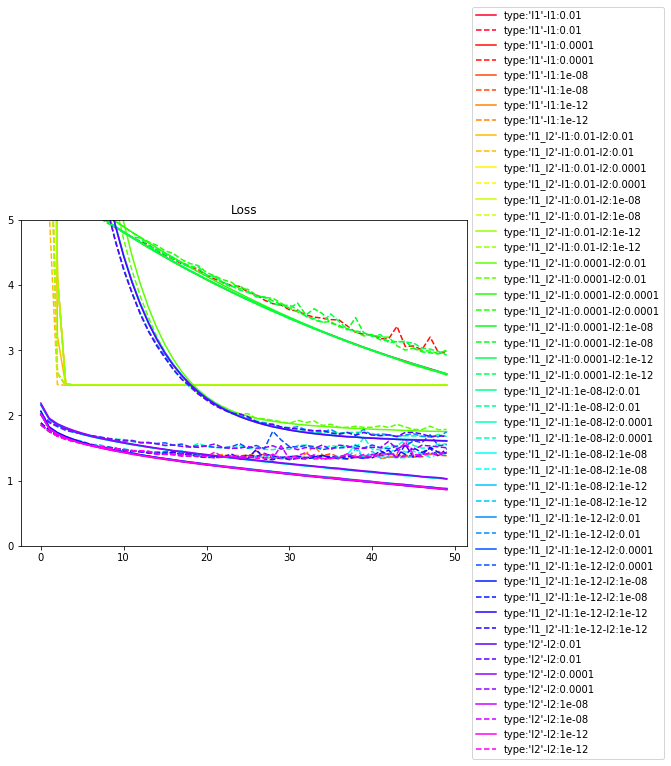

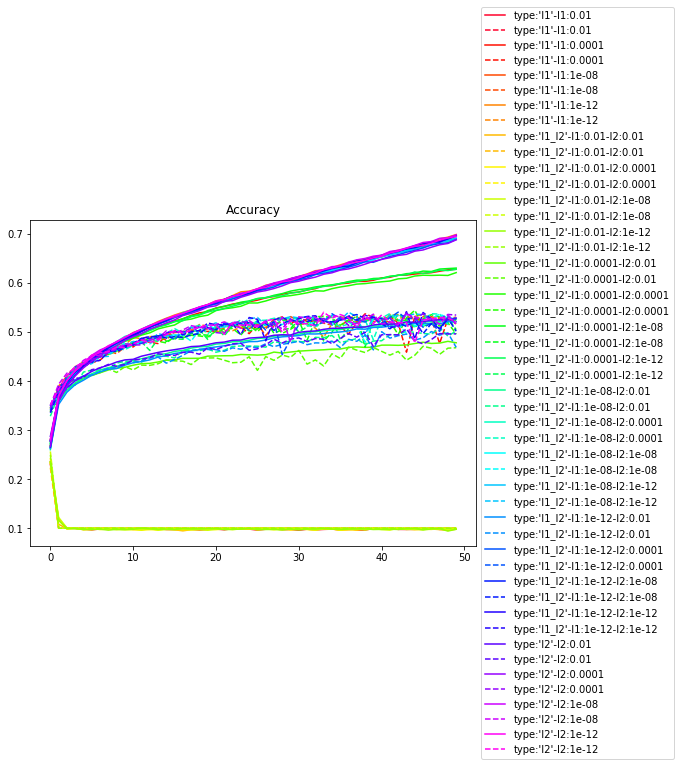

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

#color_bar = ["r", "g", "b", "y", "m", "k"]
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()